<a href="https://colab.research.google.com/github/momotonton/CSAI_assignment/blob/main/N213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Q1**

In [ ]:
pip install --upgrade scikit-learn

In [ ]:
pip install --upgrade pandas-profiling

In [ ]:
pip install --upgrade category_encoders

In [28]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from category_encoders import *

# get data
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/melbourne_house_prices/MELBOURNE_HOUSE_PRICES_LESS.csv')
# drop high cardinality cols
df.drop(columns=['Suburb','Address','SellerG','Date'], inplace=True)
# drop na values in Price
df.dropna(subset=['Price'], inplace=True)
# drop duplicated rows
df.drop_duplicates(inplace=True)

In [26]:
df.columns # 컬럼 확인

Index(['Rooms', 'Type', 'Price', 'Method', 'Postcode', 'Regionname',
       'Propertycount', 'Distance', 'CouncilArea'],
      dtype='object')

In [27]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
target = "Price"
category_features = ['Type','Method','Regionname','CouncilArea'] # 카테고리 특성으로 보고서를 토대로 직접작성
onehot = encoder.fit(df.drop(['Price'],axis=1),df[target]) # 인코더가 출력해준 카테고리 특성 

print(f'category_features의 개수는 : {len(category_features)}개')
print(f'category_features의 개수는 : {len(onehot.cols)}개')

category_features의 개수는 : 4개
category_features의 개수는 : 4개


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#Q2

In [35]:
## one-hot encoding

encoder = OneHotEncoder(use_cat_names = True)
train1 , test1 = train_test_split(df[onehot.cols], test_size=0.2, train_size=0.8, random_state=2)
X_train = encoder.fit_transform(train1)
X_test = encoder.transform(test1)

print(f'학습데이터의 첫번째 샘플의 인덱스 값은 : {X_train.index[0]}')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


학습데이터의 첫번째 샘플의 인덱스 값은 : 602


#Q3

In [44]:
from sklearn.feature_selection import f_regression, SelectKBest

df_oh = pd.get_dummies(df, prefix = category_features) # 기존 feature + 카테고리 feature
train , test = train_test_split(df_oh, test_size=0.2, train_size=0.8, random_state=2)
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test.drop(columns=target)
y_test = test[target]

selector = SelectKBest(score_func=f_regression, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((34012, 20), (8503, 20))

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

all_names = X_train.columns

## selector.get_support()
selected_mask = selector.get_support()

## 선택된 특성들
selected_names = all_names[selected_mask]

## 선택되지 않은 특성들
unselected_names = all_names[~selected_mask] 

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

In [ ]:
# Feature 갯수 너무 많이 출력되어 잘못 된것 같은데 확인 해보겠습니다.
training = []
testing = []
ks = range(1, len(X_train.columns)+1)

for k in range(1, len(X_train.columns)+ 1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_names = all_names[selected_mask]
    print('Selected names: ', selected_names)

    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    testing.append(mae)
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2} \n')

plt.plot(ks, training, label='Training Score', color='b')
plt.plot(ks, testing, label='Testing Score', color='g')
plt.ylabel("MAE ($)")
plt.xlabel("Number of Features")
plt.title('Validation Curve')
plt.legend()
plt.show()

In [48]:
column_names = X_train.columns[selector.get_support()] # feature 이름 찾기

print(f'가장 스코어(Attributes: scores_ 사용)가 높게 나온 특성의 이름은 : {column_names[0]}')

가장 스코어(Attributes: scores_ 사용)가 높게 나온 특성의 이름은 : Rooms


#Q4

In [49]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

alphas = [0, 0.001, 0.01, 0.1, 1]

ridge = RidgeCV(alphas=alphas, normalize=True, cv=5)
ridge.fit(df_oh[['Rooms']], df_oh['Price']) # 가장 스코어가 높은 Feature과 Target 설정

print("alpha: ", ridge.alpha_)
print("best score: ", ridge.best_score_)
print("best score: ", ridge.best_score_)
print(f'가장 좋은 점수가 나온 alpha 값은 : {ridge.alpha_}')

alpha:  0.0
best score:  0.17111987439725587
best score:  0.17111987439725587
가장 좋은 점수가 나온 alpha 값은 : 0.0


#Q5

Ridge Regression, alpha=0
Test MAE: $255,100
Test R2: 0.588


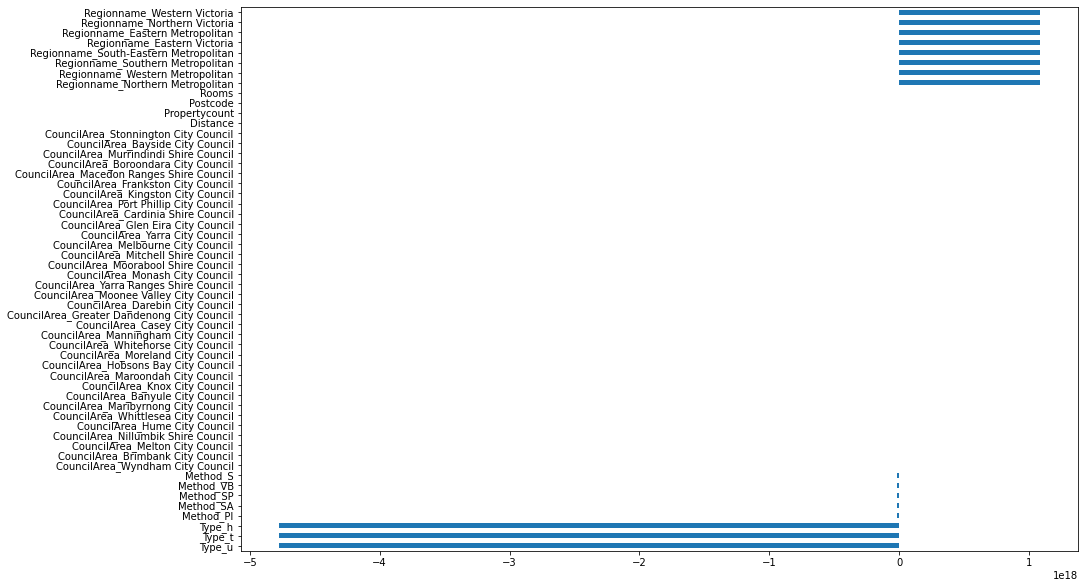

Ridge Regression, alpha=0.001
Test MAE: $255,264
Test R2: 0.588


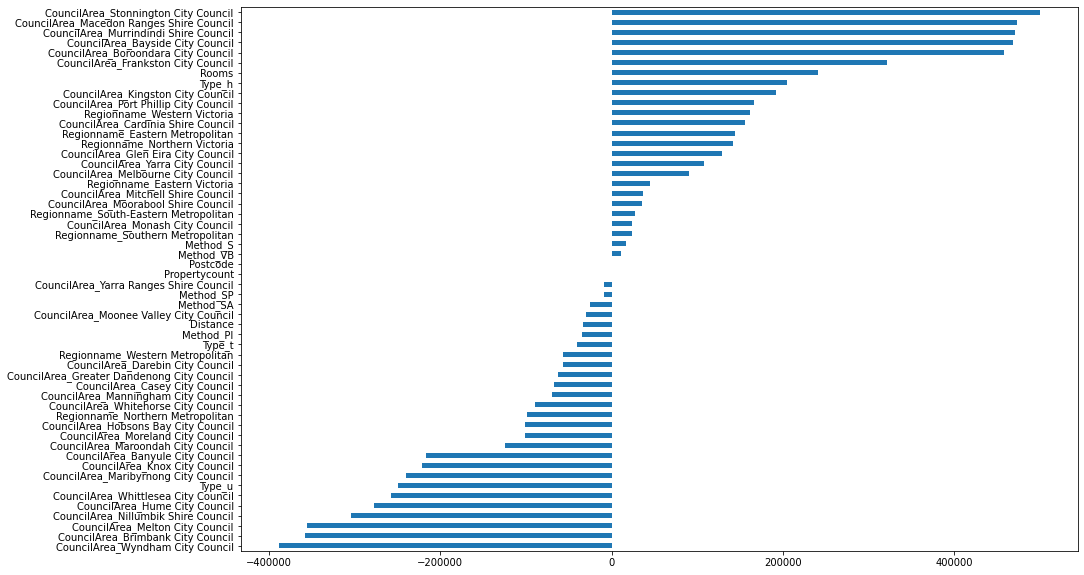

Ridge Regression, alpha=0.01
Test MAE: $254,701
Test R2: 0.587


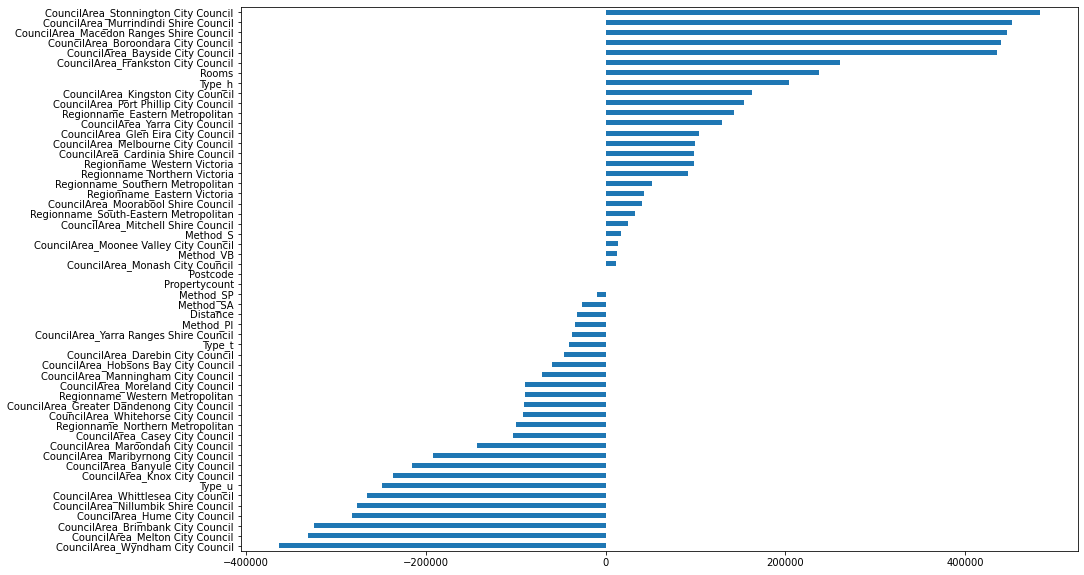

Ridge Regression, alpha=0.1
Test MAE: $252,997
Test R2: 0.579


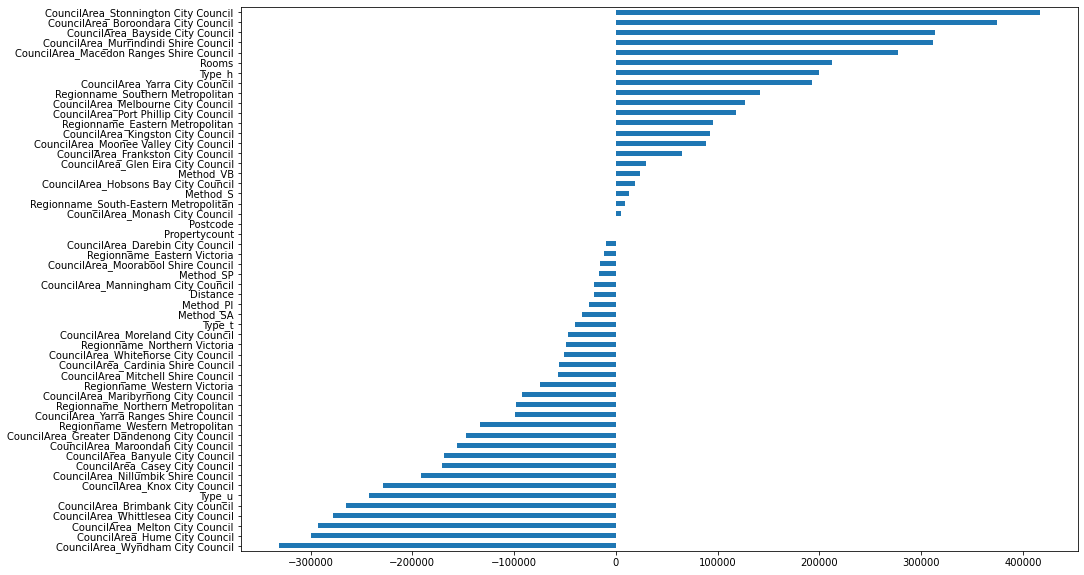

Ridge Regression, alpha=1
Test MAE: $279,498
Test R2: 0.474


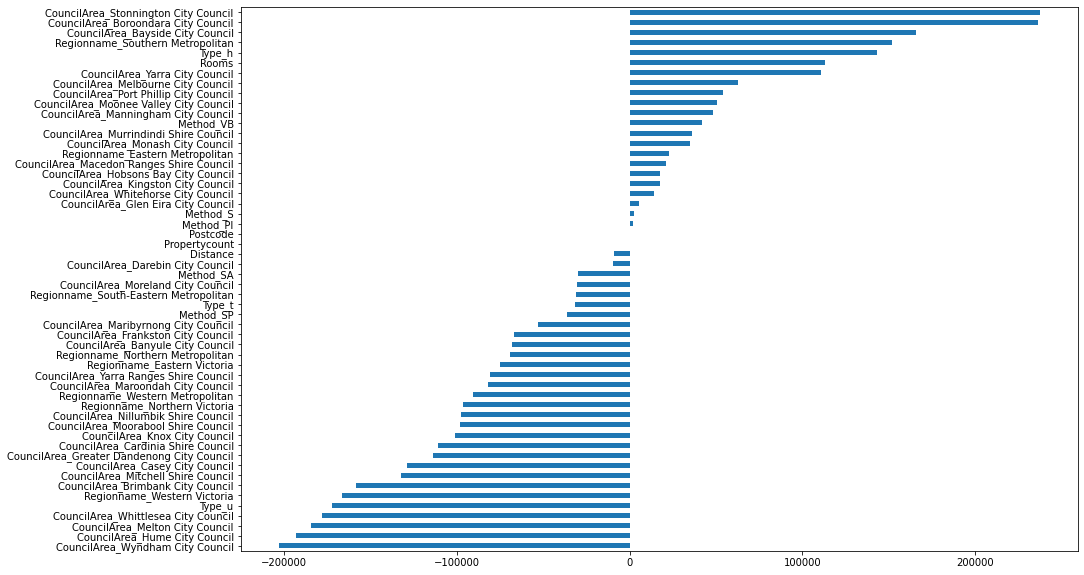

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
for alpha in [0, 0.001, 0.01, 0.1, 1]:
        
    print(f'Ridge Regression, alpha={alpha}')

    # Ridge 모델 학습
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # MAE for test
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Test MAE: ${mae:,.0f}')
    print(f'Test R2: {r2:,.3f}')
    
    # plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(15,10))
    coefficients.sort_values().plot.barh()
    plt.show()

In [54]:
for alpha in [0, 0.001, 0.01, 0.1]:
    model = Ridge(alpha=alpha, normalize=True)  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Ridge Regression, alpha={alpha}')
    print(f'테스트셋에 대한 : MAE 값 {mae:,.0f}')

Ridge Regression, alpha=0
테스트셋에 대한 : MAE 값 255,100
Ridge Regression, alpha=0.001
테스트셋에 대한 : MAE 값 255,264
Ridge Regression, alpha=0.01
테스트셋에 대한 : MAE 값 254,701
Ridge Regression, alpha=0.1
테스트셋에 대한 : MAE 값 252,997
